# ASSET ALLOCATION WITH PARAMETER UNCERTAINTY (Barberis, 2000)

In this exercise you are asked to replicate the empirical exercise described in Section 3.5 of Elliott and Timmerman (2016, pp. 59-62). This exercise illustrates the use of classical and Bayesian prediction methods based on the asset allocation problem of a buy-and-hold investor studied by Barberis (2000).

*   **See instructions for Assignment 1 Part 1.**
*   **This part will give you 100 points.**

In [1]:
# We need yfinance library for downloading stock price data from Yahoo Finance
# Other alternatives are Quandl, Intrinion, AlphaVantage, Tiingo, IEX Cloud, etc.
# However, Yahoo Finance can be considered the most popular as it is the easiest
# one to access (free and no registration required).
!pip install yfinance

In [2]:
!pip install pandas_datareader

In [3]:
import pandas as pd
import numpy as np

import yfinance as yf
import sklearn.linear_model as lm
import statsmodels.api as sm

import pandas_datareader.data as web # To download data from FRED

import matplotlib.pyplot as plt

%matplotlib inline
# This line is used for MacBooks and displays the plot in higher resolution
# for Retina displays.
%config InlineBackend.figure_format = 'retina'

There are two assets: quarterly T-bill and a stock market index. The return on the quaterly T-bill is usually taken to approximate the risk free rate $r_{f}$.

# PART 1: Getting the Data

The data on the 13-weeks T-bill rate can be obtained from the so-called [H.15 series](https://www.federalreserve.gov/releases/h15/default.htm) provided by the Federal Reserve Board (see the "Treasury bills (secondary market)" sub-section and the "3-month" sub-sub-section there) and the same data provided by the US Treasury [here](https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_bill_rates&field_tdr_date_value_month=202206) (see the "BANK DISCOUNT" column for the 13-week bill). In addition to that, the Federal Reserve Economic Data ([FRED](https://fred.stlouisfed.org/)) database provides data on the same series in a convenient format (these series are called [DTB3](https://fred.stlouisfed.org/series/DTB3); we are going to use this source). Note that H.15 also has data on "Treasury constant maturities" for 3 months, but this is something different. This is a yield curve that is calculated based on prices of many different bonds traded at a particular date.

The note about the data at the [Treasury source](https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_bill_rates&field_tdr_date_value_month=202206) (see the bottom of the page) is saying that

*Daily Treasury Bill Rates: These rates are the daily secondary market quotations on the most recently auctioned Treasury Bills for each maturity tranche (4-week, 8-week, 13-week, 26-week, and 52-week) for which Treasury currently issues new bills. Market quotations are obtained at approximately 3:30 PM each business day by the Federal Reserve Bank of New York. The Bank Discount rate is the rate at which a bill is quoted in the secondary market and is based on the par value, amount of the discount and a 360-day year.*

We need to convert this discount rate into the quarterly risk-free return.
[Here](https://www.treasurydirect.gov/instit/annceresult/press/preanre/2004/ofcalc6decbill.pdf) is an example of how we can get from the discount rate to the bond price.
Suppose that $P_n$ is a price of a \$100 treasury bill (T-bill) with maturity of 13 weeks (3 months) that expires in $n$ days. That is, in $n$ days a holder of this bill will get \$100.
The US Treasury reports the so-called *daily discount rate* as $d = \frac{100 - P_{n}}{100} \cdot \frac{360}{n} \cdot 100\%$. Using this data we can calculate
$$\dfrac{P_{n}}{100} = 1 - \dfrac{n}{360} \cdot \dfrac{d}{100\%}.$$
Observe that $R_f \equiv 100 \big/ P_n - 1$ is a return on this bill in $n$ days, and so
$$1 + R_f = \left( 1 - \dfrac{n}{360} \cdot \dfrac{d}{100\%} \right)^{-1}.$$
We usually work with log returns, and so our final formula for the return on a 13-week T-bill that expires in $n$ days is
$$r_f = - \log \left( 1 - \dfrac{n}{360} \cdot \dfrac{d}{100\%} \right).$$

Now, we observe data on $d$, but what is $n$? As it is explained [here](https://quant.stackexchange.com/a/41168):

*The Treasury says that their discount rates are determined by prices in the secondary market--- for the most recently auctioned bill. New 13-wk bills are auctioned-off every Monday. So this means that at first $n$ is approximately 91 days, but it will decline to about 85 days before a new bill is auctioned. So unless our code is responsive to the days of the week (and we do some further research about the details) we may instead want to consider making an approximation.*

Thus, for our purposes, we can just take data on $d$ at the end of each quarter and use $n = 90$ (which is an appromixation). The logic is the following: at the end of each quarter we buy a \$100$ T-bill for the price $P_{90}$, hold the bill till its maturity at the end of the next quarter, get $100 for it, buy the next bill, and repeat.

In [4]:
N_DAYS = 90
START_DATE = '1994-01-01'
END_DATE = '2013-12-31'

df_dtb3 = web.DataReader('DTB3', 'fred', start=START_DATE, end=END_DATE)
# Resample the data to quarterly frequency
# (by taking the last value for each quarter).
# Data is in percent, so we divide by 100.
d = df_dtb3.resample('QS').last().DTB3
# Parameter 'QS' means 'Quarter Start': this means that the date is taken
# for the start of each quarter (Jan 1, Apr 1, Jul 1, and Oct 1).
# This is different from last(), which tells us to take the value of the last
# day of each quarter.

# Now we calculate the return at the end of each quarter.
# Instead of working with simple returns, we will work with log returns:
rf = -np.log(1 - N_DAYS / 360 * d / 100)
# NB: There is no need to multiply this by the length of a quarter (90 or
# 91 days) to translate this into quarterly returns, because these returns are
# already on a quarterly basis: we calculated them as the difference in the
# index between the end days of two consecutive quarters.

In [5]:
rf

DATE
1994-01-01    0.008738
1994-04-01    0.010429
1994-07-01    0.011744
1994-10-01    0.013921
1995-01-01    0.014353
                ...   
2012-10-01    0.000125
2013-01-01    0.000175
2013-04-01    0.000100
2013-07-01    0.000050
2013-10-01    0.000175
Freq: QS-JAN, Name: DTB3, Length: 80, dtype: float64

Another source of the data for the 13-week Treasury bill returns is [Yahoo!Finance](https://finance.yahoo.com/quote/%5EIRX/history?p=%5EIRX), which provides the value of the 13-week Treasury index (ticker: ^IRX). This index is also based on the discount rate of the most recently auctioned 13-week U.S. T-bill (I wasn't able to figure out how and by whom exactly this index is calculated).

The data from Yahoo!Finance slightly differs from the H.15 series. I am not sure where this difference is coming from. Perhaps, this difference arises because IRX is not calculated based on the bills traded at the same platform where the New York Fed collects the data for the Treasury. Or, perhaps, IRX is calculated at a different time of the day. But, anyway, the difference is relatively small.

In [6]:
# The 13 Week (3-month) Treasury Bill is available at Yahoo finance with
# ticker ^IRX
df_yf = yf.download('^IRX', start=START_DATE, end=END_DATE,
                   progress=False)
d_yf = df_yf.resample('QS').last().Close
rf_yf = -np.log(1 - N_DAYS / 360 * d_yf / 100)

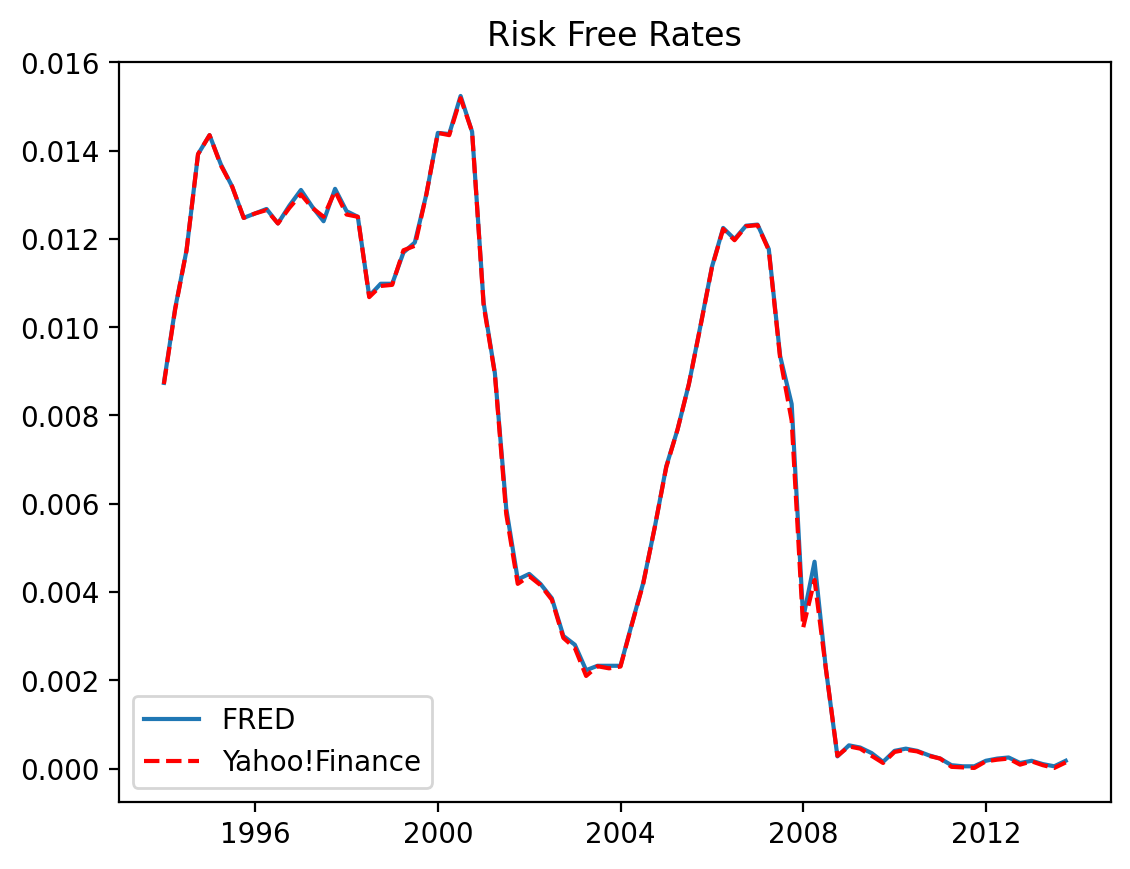

In [7]:
# We can compare the calculated rates:

fig, ax = plt.subplots()
ax.plot(rf.index, rf, label='FRED')
ax.plot(rf_yf.index, rf_yf, '--r', label='Yahoo!Finance')
ax.set_title("Risk Free Rates")
ax.legend(loc='lower left')

We will use the data on the S&P500 stock market index. Based on this index, we calculate the continuously compounded excess return on stocks, $y_t$.


They don't coincide fully. better trust official info.

In [8]:
#-- CALCULATE THE STOCK MARKET EXCESS RETURN

# We are going to use the S&P500 index - as a mraket rate
df_sp500 = yf.download('^GSPC', start=START_DATE, end=END_DATE,
                       progress=False)
# We calculate the returns between ends of each two consecutive quarters: 
y_it = df_sp500['Adj Close'].resample('QS').last()
# Instead of working with simple returns, we will work with log returns:
y_it = np.log(1 + y_it.pct_change().dropna())
# NB: There is no need to multiply this by the length of a quarter (90 or
# 91 days) to translate this into quarterly returns, because these returns are
# already on a quarterly basis: we calculated them as the difference in the
# index between the end days of two consecutive quarters.

y_it = y_it - rf

In [9]:
y_it

1994-01-01         NaN
1994-04-01   -0.013800
1994-07-01    0.028924
1994-10-01   -0.021384
1995-01-01    0.072036
                ...   
2012-10-01   -0.010227
2013-01-01    0.095378
2013-04-01    0.023261
2013-07-01    0.045745
2013-10-01    0.090456
Freq: QS-JAN, Length: 80, dtype: float64

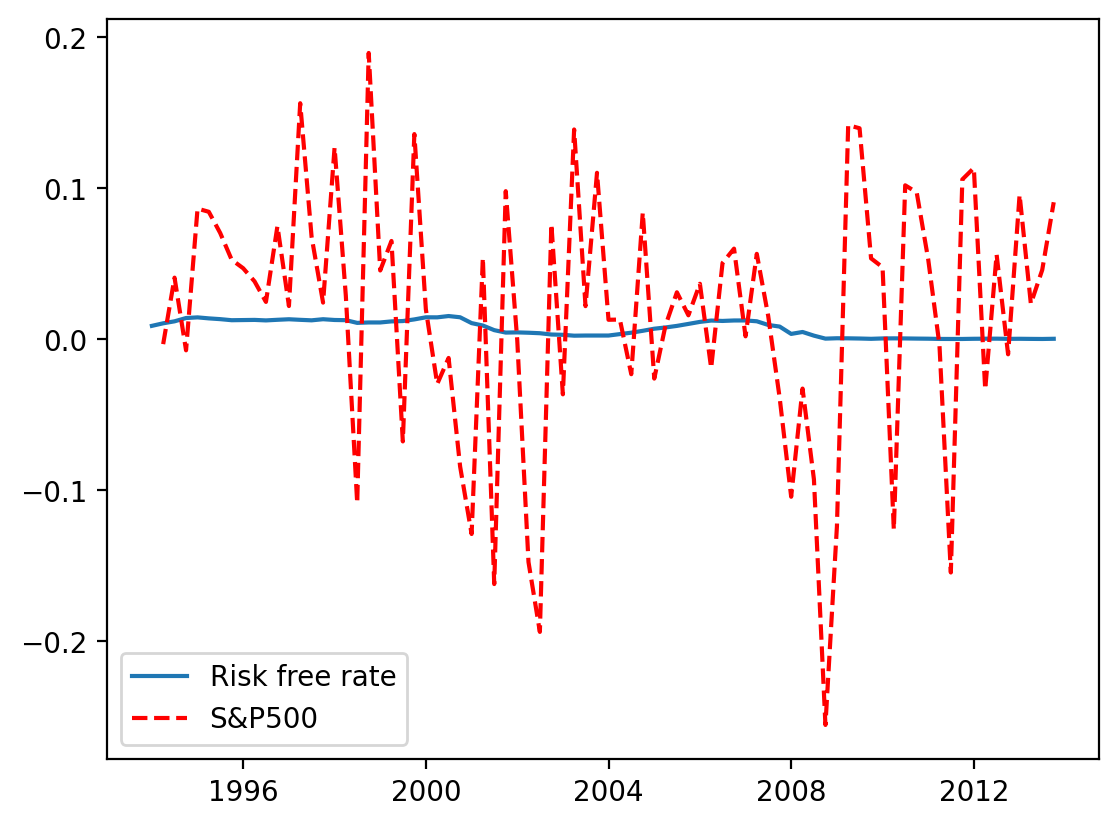

In [10]:
fig, ax = plt.subplots()
ax.plot(rf.index, rf, label='Risk free rate')
ax.plot(y_it.index, y_it + rf, '--r', label='S&P500')
ax.legend(loc='lower left')

# PART 2: Asset Allocation with Parameter Uncertainty

Suppose that the excess return on stocks, $y_t$, is independently and identically distributed:
$$y_t=\mu+\varepsilon_t, \;\;\varepsilon_t\sim \textrm{ind}\;\textrm{N}(0,\sigma^2) \tag{1}$$

A buy-and-hold invesrtor's asset allocation decision at time $T$ for an $h$-period investment horizon as follows. Investor's initial wealth is set at $W_T=1$ and $\omega(z)$ is an allocation to the stock index. Hence, the investor's terminal wealth at time $T+h$ can be given by:
\begin{align*}
W_{T+h} = \left( 1-\omega(z) \right) \exp \left( r_fh \right)
+ \omega(z) \exp \left( r_fh + \sum_{\tau=1}^h y_{T+\tau} \right) \tag{2}
\end{align*}
And suppose that the investor has a power utility over terminal wealth:
\begin{align*}
u \left( W_{T+h} \right) = \frac{W_{T+h}^{1-A}}{1-A}, \tag{3}
\end{align*}
where $A$ is the coefficient of relative risk aversion. This utility function plays the role of the loss function with the difference that we seek to maximize expected utility rather than minimizing expected loss.

The investor maximizes the value of $\omega(z)$ as:
\begin{align*}
\omega^*(z)=\arg\max_{\omega(z)\in[0,1)} E \left[ \frac{W_{T+h}^{1-A}}{1-A} \middle| Z_T \right] \tag{4}
\end{align*}
To control for bankruptcy and unbounded expected utility, the weight on stocks is restricted to lie in $[0, 1)$ interval.

The classical and Bayesian methods differ in how they compute the expectation in (4).

## PART 2.1: Portfolio Under the Classical Plug-In Approach

Under the classical plug-in approach, the investor conditions on the parameter estimates $\hat{\theta} = \left(\hat{\mu},\hat{\sigma}^2 \right)$ and solves the following optimization problem:
\begin{align*}
\max_{\omega(z)\in[0,1)} \int \cdots \int u \left( W_{T+h}(\omega(z)) \right) p_Y \left( \sum_{\tau=1}^hy_{T+\tau} \middle| Z_T, \hat{\theta} \right) dy_{T+1} \cdots dy_{T+h} \tag{5}
\end{align*}
It follows from (1) that $p_Y \left( \sum_{\tau=1}^hy_{T+\tau} \middle| Z_T, \hat{\theta} \right) = \mathrm{N} \left( \hat{\mu} h, \hat{\sigma}^{2} h \right)$.
The solution ignores that $\theta$ is not known but typically estimated with considerable error.

To solve for the optimal value of $\omega(z)$, take a grid of values $\omega = 0, 0.01, 0.02, \cdots, 0.99$, and compute the integral in (5) by numerical simulation. For that, draw a large number of cumulated returns, $\left\{ y_{T+1:T+h}^i \right\}_{i=1}^I$ and then compute:
\begin{align*}
\bar{U}(\omega(z)) =
\frac{1}{I}\sum_{i=1}^I \dfrac{ \left[ \left( 1-\omega(z) \right) \exp \left( r_fh \right)
+ \omega(z) \exp \left( r_fh + \sum_{\tau=1}^h y_{T+\tau}^{i} \right) \right]^{1-A}  }{1-A} \tag{6}
\end{align*}

This calculation is straightforward:

1) Given the assumption of normally distributed data, simply draw $I$ times from $\mathrm{N} \left( \hat{\mu} h, \hat{\sigma}^{2} h \right)$;

2) For each draw $i$ compute $\sum_{\tau=1}^h y_{T+\tau}^{i}$; #don't need it- already drew from the sum

3) Evaluate the utility function for a given value of $\omega(z)$ and average this across $I$.

The value of $\omega(z)$ that yields the highest value of (6) is then the optimal allocation to stocks, $\omega^{*}(z)$.

Assume the coefficient of relative risk aversion of $A = 5$.

**Calculate the optimal portofolio for the horizon $ h = 1, 2, \dots, 40$ quarters.**

2) - don't need

In [11]:
mu = y_it.mean()
variation = y_it.var()
r = rf[-1]

\begin{align*}
\bar{U}(\omega(z)) =
\frac{1}{I}\sum_{i=1}^I \dfrac{ \left[ \left( 1-\omega(z) \right) \exp \left( r_fh \right)
+ \omega(z) \exp \left( r_fh + \sum_{\tau=1}^h y_{T+\tau}^{i} \right) \right]^{1-A}  }{1-A} \tag{6}
\end{align*}

In [13]:
I = 10000
A = 5
H = 40
omega_grid_size = 100

y_non_scaled = np.random.normal(loc=0, scale=1, size=I)

omega = np.linspace(0, 1, omega_grid_size)
Utility = np.zeros((H, omega_grid_size))
best_omegas = np.zeros(H)

for h in range(1,H+1):
    y_sum_draw = y_non_scaled*np.sqrt(variation*h) + mu*h #controlling randomness, related to approximation
    for w in range(len(omega)):
        Utility_sum = 0
        for i in range(I):
            Utility_sum += (((1 - omega[w])*np.exp(r*h) + omega[w]*np.exp(r*h + y_sum_draw[i]))**(1-A)/(1-A))  
        Utility[h-1][w] = Utility_sum/I
    best_omegas[h-1] = omega[np.argmax(Utility[h-1])]

In [14]:
Utility

array([[-0.24982505, -0.24968381, -0.24954656, ..., -0.25368559,
        -0.2539124 , -0.25414335],
       [-0.24965021, -0.24936267, -0.24908356, ..., -0.25698671,
        -0.25744274, -0.25790788],
       [-0.24947551, -0.24903937, -0.24861656, ..., -0.26019158,
        -0.26088254, -0.26158843],
       ...,
       [-0.2434371 , -0.23651746, -0.23024694, ..., -0.34743058,
        -0.36003441, -0.37373927],
       [-0.24326674, -0.23612225, -0.22966425, ..., -0.34925212,
        -0.36228715, -0.37648961],
       [-0.2430965 , -0.23572478, -0.22907837, ..., -0.35103483,
        -0.36450504, -0.37921158]])

In [15]:
best_omegas

array([0.38383838, 0.38383838, 0.38383838, 0.39393939, 0.39393939,
       0.39393939, 0.39393939, 0.39393939, 0.39393939, 0.39393939,
       0.39393939, 0.39393939, 0.39393939, 0.39393939, 0.39393939,
       0.39393939, 0.39393939, 0.39393939, 0.39393939, 0.39393939,
       0.39393939, 0.39393939, 0.39393939, 0.39393939, 0.39393939,
       0.39393939, 0.39393939, 0.39393939, 0.39393939, 0.39393939,
       0.39393939, 0.39393939, 0.39393939, 0.39393939, 0.39393939,
       0.39393939, 0.39393939, 0.39393939, 0.39393939, 0.39393939])

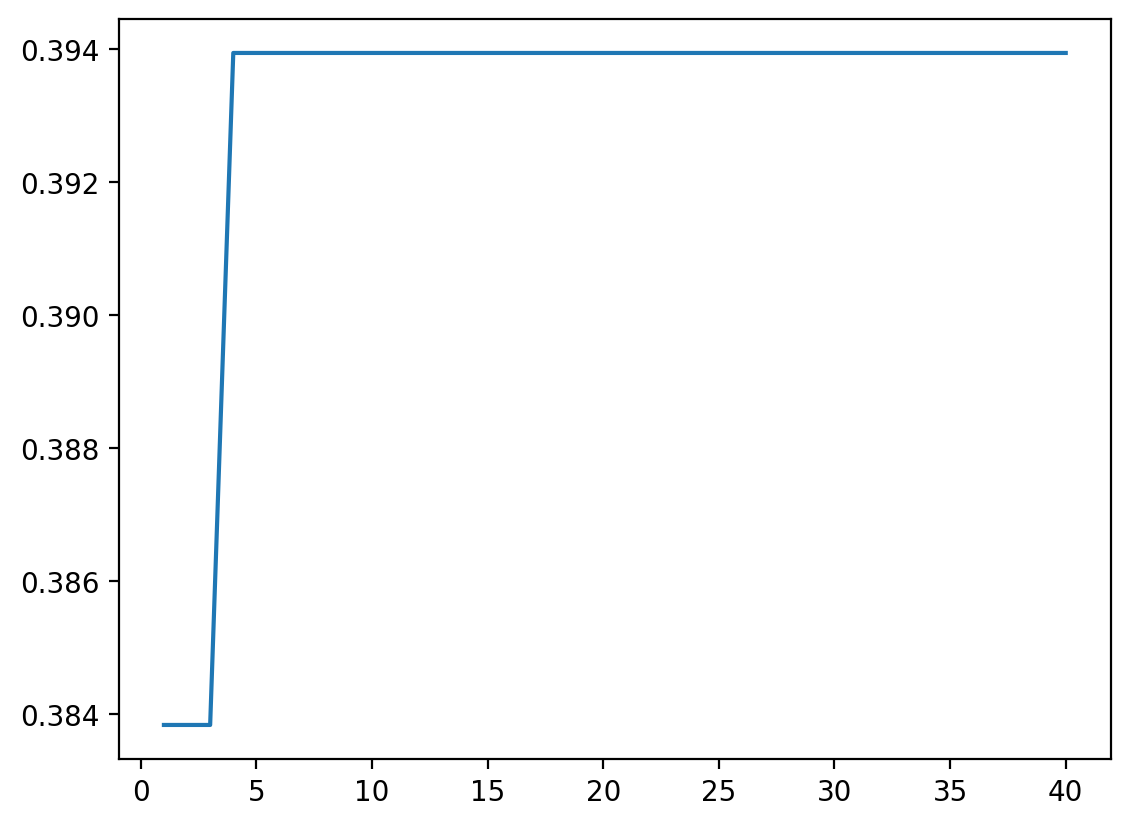

In [16]:
plt.plot(range(1,len(best_omegas)+1), best_omegas)

Same portfolio for different horizons.

## PART 2.2: Portfolio Under the Bayesian Approach

The Bayesian approach deals with parameter uncertainty by integrating over the posterior distribution $p_Y \left( \theta \middle| z_T \right)$, which summarizes the uncertainty about the parameters given the observed data sample $z_T$. This leads to a predictive distribution that is  conditioned only on the observed sample (and not on any estimate $\hat{\theta}$): 
\begin{align*}
p_y \left( \sum_{\tau=1}^h y_{T+\tau} \middle| Z_T \right)
= \int p_Y \left( \sum_{\tau=1}^h y_{T+\tau} \middle| Z_T, \theta \right) p\left( \theta \middle| Z_T \right)d \theta. \tag{7}
\end{align*}
The Bayesian investor therefore solves:
\begin{align*}
\max_{\omega(z)\in[0,1)} \int \cdots \int u \left( W_{T+h}(w(z)) \right) p_Y \left( \sum_{\tau=1}^h y_{T+\tau}\middle| Z_T, \theta \right) p \left( \theta \middle| Z \right) d y_{T+1} \cdots dy_{T+h} d \theta. \tag{8}
\end{align*}
This can be evaluated by sampling from the posterior distribution for $\theta$, and, conditional on this draw, sampling from $p_Y \left( \sum_{\tau=1}^h y_{T+\tau} \middle| Z_T, \theta \right)$, and finally averaging $u \left( W_{T+h} \right)$ across those draws.

Assume an uninformative prior, $p \left( \mu, \sigma^2 \right) \propto \sigma^{-2}$, and utilize a normal-inverse gamma (IG) posterior distribution of Zellner (1971):
\begin{align*}
\left. \sigma^2 \middle| Z_T \right. &\sim
\mathrm{IG} \left( \frac{T-1}{2},\frac{1}{2} \sum_{t=1}^{T} \left( y_t-\bar{y}_T \right)^2 \right), \tag{9}\\
%%%%
\left. \mu \middle| \sigma^2,Z_T \right. &\sim \mathrm{N}\bigg(\bar{y}_T,\frac{\sigma^2}{T}\bigg), \tag{10}
\end{align*}
where $\bar{y}_T=\frac{1}{T}\sum_{t=1}^Ty_t$ is the sample mean.

To sample from the predictive distribution in the Bayesian sense, $p_Y \left( \sum_{\tau=1}^h y_{T+\tau} \middle| Z_T \right)$, ﬁrst generate a sample $\left(\mu, \sigma^{2} \right)$ from the posterior distribution for the parameters $p \left( \mu, \sigma^2 \middle| Z_{T} \right)$. Then sample from the distribution of long-horizon returns conditional on past data and the parameters, $p_Y \left( \sum_{\tau=1}^h y_{T+\tau} \middle| Z_T, \mu, \sigma^{2} \right)$. Finally, each of these draws is plugged into the utility function and averaged across the $I$ draws to get an estimate of the average utility for a given value of $\omega (z)$.

Sampling from the posterior return distribution is very easy:

1) First, we sample from the marginal distribution, $p \left( \sigma^2 \middle| Z_T \right)$, which by (9) is an inverse Gamma distribution;

2) Given a value for $\sigma^{2}$, we next sample from the conditional distribution $p \left( \mu \middle| \sigma^2,Z_T \right)$, which by (10) is a normal distribution;

3) Sample from the distribution of returns conditional on the parameter values $p_Y \left( \sum_{\tau=1}^h y_{T+\tau} \middle| Z_T, \mu, \sigma^{2} \right)$.

**Calculate the optimal portofolio for the horizon $ h = 1, 2, \dots, 40$ quarters. Compare your result with the classical approach.** 

In [ ]:
# <YOUR CODE GOES HERE>